# Thermal history

## Saha equation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as const
import astropy.units as u
from scipy.special import zeta
from astropy.cosmology import Planck18, WMAP7, FlatLambdaCDM

In [2]:
Planck18 # = WMAP7

T0 = Planck18.Tcmb0  # K
H0 = Planck18.H0  # 70 * u.km / u.s / u.Mpc
BH = 13.6 * u.eV  # eV
Omegab0 = Planck18.Ob0
Omegam0 = Planck18.Om0
age = Planck18.lookback_time(np.inf)
rhoc0 = (3 * H0**2 / (8 * np.pi * const.G) / const.m_p).to(1/u.m**3)
sigmaT = 6.6529e-29 * u.m**2
Planck18.Ogamma0

5.402015137139352e-05

## Constants

In [3]:
cosmo = FlatLambdaCDM(H0=H0, Om0=Omegam0, Tcmb0=T0, m_nu=0)
Omegar0 = cosmo.Ogamma0 + cosmo.Onu0  # with massless neutrinos
Omegar0

9.131600127112836e-05

In [4]:
rhoc0

<Quantity 5.14091926 1 / m3>

$$T(z) = T_0 (1+z)$$

In [5]:
def T(z):
    return T0 * (1+z)

$$n_\gamma = \frac{2\zeta(3)}{\pi^2}\left(\frac{k_B T}{\hbar c}\right)^3$$

In [6]:
def ng(T):
    prefactor = 2 * zeta(3) / np.pi**2
    return prefactor * (const.k_B * T / (const.hbar * const.c))**3

In [7]:
ng(T0)

<Quantity 4.10726848e+08 1 / m3>

$$n_b(z) = \Omega_b^0 \rho_c^0 (1+z)^3/m_p$$

In [8]:
def nb(z):
    return Omegab0 * rhoc0 * (1+z)**3

In [9]:
nb(0)

<Quantity 0.25175082 1 / m3>

In [10]:
eta = nb(0) / ng(T0)
eta

<Quantity 6.12939761e-10>

$$\eta = \frac{n_b}{n_\gamma} = \frac{\Omega_b^0 \rho_c^0}{m_p n^0_\gamma} = 2.73\times 10^{-8}\times \Omega_b^0 h^2 =  6.2 \times 10^{-10}$$

In [11]:
eta_obh2 = nb(0) / ng(T0) / (Omegab0 * (H0.value / 100)**2)
eta_obh2

<Quantity 2.7341586e-08>

## Electron fraction

$$\frac{1-X_e}{X_e^2} = \eta n_\gamma(T) \left(\frac{m_e k_B T}{2 \pi \hbar^2}\right)^{-3/2} \exp\left(\frac{B_H}{k_B T}\right) \equiv c$$

In [12]:
def c(T):
    exp = np.exp(BH.to(u.J)/ (const.k_B * T))
    factor = eta * (ng(T) * (const.m_e * const.k_B * T / (2 * np.pi * const.hbar**2)) **(-3/2)).to(u.dimensionless_unscaled)
    return (factor * exp).value

In [13]:
c(T(100)), np.exp(BH.to(u.J)/ (const.k_B * T(10)))

/Users/jneveu/miniforge3/envs/m2-cosmo/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


(2.301016207602902e+229, <Quantity inf>)

In [14]:
T(100)

<Quantity 275.2755 K>

In [15]:
def Xe(T):
    Ttmp = np.atleast_1d(T)
    out = np.zeros_like(Ttmp).value
    # high T
    indhigh = Ttmp >= 300 * u.K
    out[indhigh] = (-1 + np.sqrt(1 + 4*c(Ttmp[indhigh])))/(2*c(Ttmp[indhigh]))
    #else low T is 1/sqrt(c)
    indlow = ~indhigh
    Tlow = Ttmp[indlow]
    exp = np.exp(-BH.to(u.J)/ (2 * const.k_B * Tlow))
    factor = np.sqrt(eta * (ng(Tlow) * (const.m_e * const.k_B * Tlow / (2 * np.pi * const.hbar**2)) **(-3/2)).to(u.dimensionless_unscaled))
    out[indlow] = (exp / factor).value
    return out
    # return 1  # fully ionized at redshift 10

def ne(T):
    return Xe(T) * eta * ng(T)

In [16]:
T(100)

<Quantity 275.2755 K>

In [17]:
Xe(T(100))

array([2.08468365e-115])

In [18]:
zz = np.linspace(1000, 1800, 100)

In [19]:
from scipy.optimize import brentq
zrec = brentq(lambda z: Xe(T(z))-1/2, 1200, 1600)
zrec

1378.7603205637458

In [20]:
Trec = T(zrec)
Trec

<Quantity 3760.5367537 K>

In [21]:
def z_to_t(z):
    return Planck18.age(z).to(u.yr).value

In [22]:
z_to_t(zrec)

249914.7782081686

In [23]:
tt = z_to_t(zz)

def t_to_z(t):
    return np.interp(t, tt, zz)

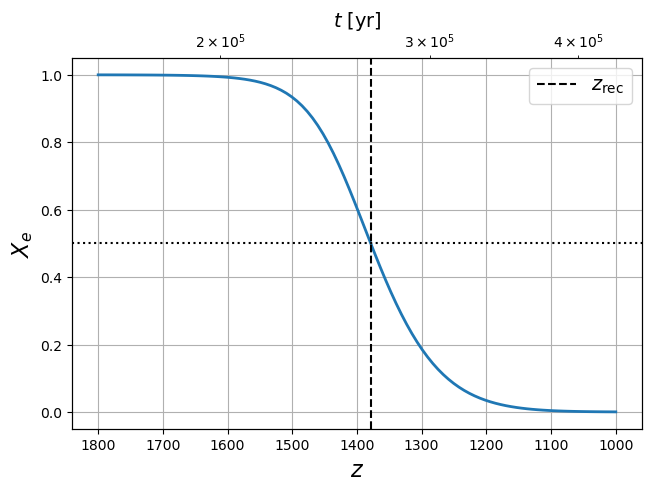

In [24]:
#| label: saha_Xe
zz = np.linspace(1000, 1800, 100)

fig, ax1 = plt.subplots(constrained_layout=True)
plt.plot(zz, [Xe(TT) for TT in T(zz)], lw=2)
plt.axvline(zrec, color="k", linestyle="--", label="$z_{\mathrm{rec}}$")
plt.axhline(0.5, color="k", linestyle=":")
plt.xlabel("$z$", fontsize=16)
plt.ylabel("$X_e$", fontsize=16)
plt.legend(fontsize=14)
plt.grid()
ax1.invert_xaxis()

secax = ax1.twiny()
secax.plot(tt, [Xe(T(t_to_z(ttt))) for ttt in tt], linestyle="none")
secax.set_xscale("log")
secax.set_xlabel('$t$ [yr]', fontsize=14)

plt.show()

In [25]:
BH.to(u.J) / (const.k_B * T(zrec))

<Quantity 41.96779789>

Magic number !

## Decoupling

$$X_e(T_\mathrm{dec}) (k_B T_\mathrm{dec})^{3/2} \approx  \frac{\pi^2}{2\zeta(3)}\frac{H_0 \sqrt{\Omega_m^0} } {\eta  \sigma_T c} \left(\frac{k_B T_0}{\hbar c}\right)^{-3/2}$$

In [26]:
def dec_f(T):
    return (Xe(T)*(const.k_B * T)**(3/2)).to(u.J**(3/2))

C = np.pi**2/(2*zeta(3))* H0*np.sqrt(Omegam0)/(eta*sigmaT*const.c)*(const.k_B * T0/(const.hbar * const.c)**2)**(-3/2)
C.to(u.J**(3/2))

<Quantity 5.60938981e-32 J(3/2)>

In [27]:
dec_f(Trec)

<Quantity [5.91520343e-30] J(3/2)>

In [28]:
Tdec = brentq(lambda T: (dec_f(T*u.K)-C).value, 2800, 3200)*u.K
Tdec

<Quantity 3055.04391722 K>

In [29]:
(const.k_B * Tdec).to(u.eV)

<Quantity 0.26326332 eV>

In [30]:
zdec = brentq(lambda z: (T(z)-Tdec).value, 1000, 1200)
zdec

1119.9113620310331

In [31]:
Xe(Tdec)

array([0.00647537])

In [32]:
tdec = z_to_t(zdec) * u.yr
tdec

<Quantity 355616.70730071 yr>

## Last scattering

In [33]:
from scipy.integrate import quad

def Gamma(z):
    return (sigmaT * const.c * eta * ng(T(z)) * Xe(T(z))).to(1/u.s)

def H(z):
    return Planck18.H(z).to(1/u.s)

def tau(z):
    return quad(lambda zz: (Gamma(zz)/(H(zz)*(1+zz))).to(u.dimensionless_unscaled), 0, z)[0]

tau(1100)

0.019315208743039495

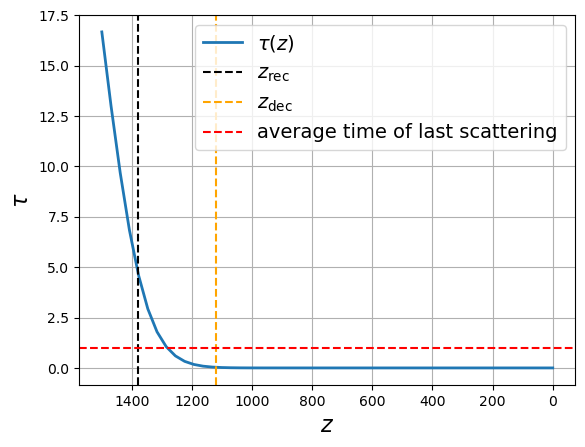

In [34]:
fig = plt.figure()
zz = np.linspace(1500, 0, 50)
plt.plot(zz, [tau(z) for z in zz], lw=2, label=r"$\tau(z)$")
#plt.plot(zz, H(zz), label="$H(z)$")
plt.gca().invert_xaxis()
#plt.xscale("log")
plt.axvline(zrec, color="k", linestyle="--", label="$z_{\mathrm{rec}}$")
plt.axvline(zdec, color="orange", linestyle="--", label="$z_{\mathrm{dec}}$")
plt.axhline(1, color="r", linestyle="--", label="average time of last scattering")
#plt.yscale("log")
plt.legend(fontsize=14)
plt.xlabel("$z$", fontsize=16)
plt.ylabel(r"$\tau$", fontsize=16)
plt.grid()
plt.show()

The solution $\tau=1$ does not agree with $z_{dec}$ because more complex out-of-equilibrium physics must be taken into account.

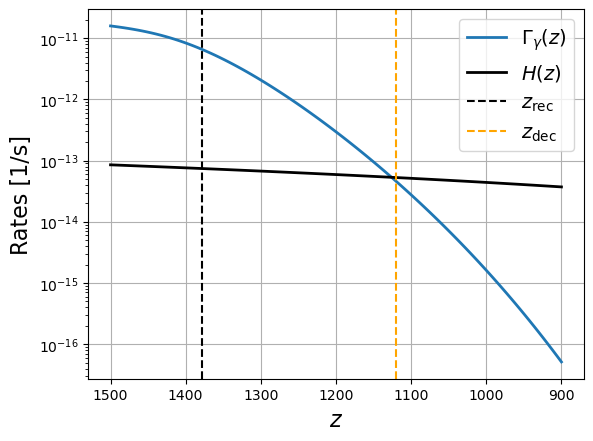

In [35]:
#| label: rates_decoupling

fig = plt.figure()
zz = np.linspace(1500, 900, 100)
plt.plot(zz, Gamma(zz), lw=2, label="$\Gamma_\gamma(z)$")
plt.plot(zz, H(zz), lw=2, color="k", label="$H(z)$")
plt.gca().invert_xaxis()
#plt.xscale("log")
plt.axvline(zrec, color="k", linestyle="--", label="$z_{\mathrm{rec}}$")
plt.axvline(zdec, color="orange", linestyle="--", label="$z_{\mathrm{dec}}$")
plt.yscale("log")
plt.legend(fontsize=14)
plt.xlabel("$z$", fontsize=16)
plt.ylabel("Rates [1/s]", fontsize=16)
plt.grid()
plt.show()

## Free mean path

In [36]:
def lpm(z):
    return 1/(sigmaT * ne(T(z)) )

def tauT(z):
    return lpm(z)/const.c

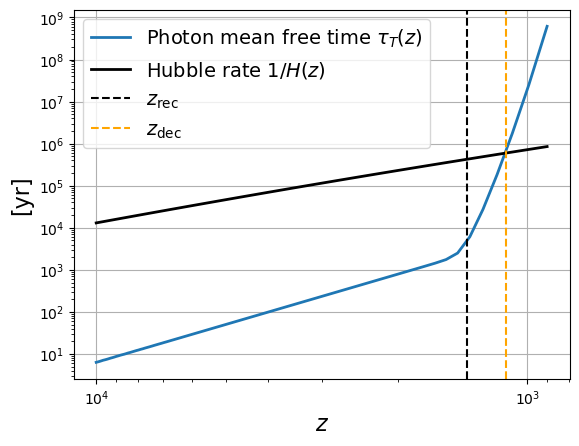

In [37]:
#| label: photon_rates

fig = plt.figure()
zz = np.linspace(10000, 900, 100)
plt.plot(zz, tauT(zz).to(u.yr), lw=2, label=r"Photon mean free time $\tau_T(z)$")
plt.plot(zz, (1/H(zz)).to(u.yr), lw=2, color="k", label="Hubble rate $1/H(z)$")
plt.gca().invert_xaxis()
plt.xscale("log")
plt.axvline(zrec, color="k", linestyle="--", label="$z_{\mathrm{rec}}$")
plt.axvline(zdec, color="orange", linestyle="--", label="$z_{\mathrm{dec}}$")
plt.yscale("log")
plt.legend(fontsize=14)
plt.xlabel("$z$", fontsize=16)
plt.ylabel("[yr]", fontsize=16)
plt.grid()
plt.show()

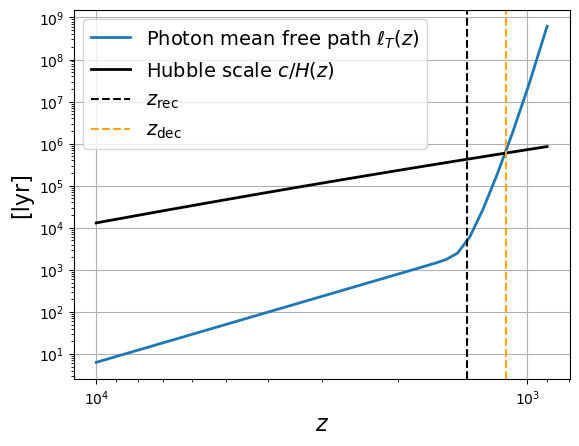

In [38]:
#| label: photon_mean_free_path

fig = plt.figure()
zz = np.linspace(10000, 900, 100)
plt.plot(zz, lpm(zz).to(u.lyr), lw=2, label=r"Photon mean free path $\ell_T(z)$")
plt.plot(zz, (const.c/H(zz)).to(u.lyr), color="k", lw=2, label="Hubble scale $c/H(z)$")
plt.gca().invert_xaxis()
plt.xscale("log")
plt.axvline(zrec, color="k", linestyle="--", label="$z_{\mathrm{rec}}$")
plt.axvline(zdec, color="orange", linestyle="--", label="$z_{\mathrm{dec}}$")
plt.yscale("log")
plt.legend(fontsize=14)
plt.xlabel("$z$", fontsize=16)
plt.ylabel("[lyr]", fontsize=16)
plt.grid()
plt.show()

### Reionization

We assume that Universe if fully ionized.

In [39]:
def Gamma(z):
    return (sigmaT * const.c * eta * ng(T(z))).to(1/u.s)

def H(z):
    return Planck18.H(z).to(1/u.s)

def tau(z):
    return quad(lambda zz: (Gamma(zz)/(H(zz)*(1+zz))).to(u.dimensionless_unscaled), 0, z)[0]

tau(6.5)

0.05142931519864634

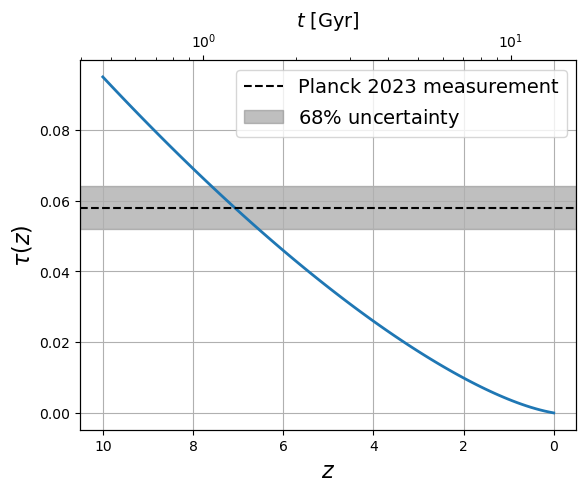

In [40]:
#| label: tau_reio

zz = np.linspace(10, 0, 100)
tt = z_to_t(zz)

fig = plt.figure()
plt.plot(zz, [tau(z) for z in zz], lw=2)
#plt.plot(zz, H(zz), label="$H(z)$")
plt.gca().invert_xaxis()
#plt.xscale("log")
plt.axhline(0.058, color="k", linestyle="--", label="Planck 2023 measurement")
plt.axhspan(0.052, 0.064, color="gray", alpha=0.5, label="$68\%$ uncertainty")
#plt.yscale("log")
plt.legend(fontsize=14)
plt.xlabel("$z$", fontsize=16)
plt.ylabel(r"$\tau(z)$", fontsize=16)
plt.grid()

secax = plt.gca().twiny()
secax.plot(tt*1e-9, [tau(t_to_z(ttt)) for ttt in tt], linestyle="none")
secax.set_xscale("log")
secax.set_xlabel('$t$ [Gyr]', fontsize=14)

plt.show()